# Appendix B

## Bidirectional Long Short-Term Memory Analysis on HARTH Dataset
## Name: Greg Moore
## Date: 8/12/2024

In [2]:
# import libraries
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

## Data Pre-processing
### Load 22 HARTH dataset files with Human Activity Recognition Sensor Data

In [3]:
# Load data from URL for UCI HARTH dataset into dataframes
zip_file_url = "https://archive.ics.uci.edu/static/public/779/harth.zip"
files = ['S006.csv', 'S008.csv', 'S009.csv', 'S010.csv', 'S012.csv', 'S013.csv',
         'S014.csv', 'S015.csv', 'S016.csv', 'S017.csv', 'S018.csv', 'S019.csv',
         'S020.csv', 'S021.csv', 'S022.csv', 'S023.csv', 'S024.csv', 'S025.csv',
         'S026.csv', 'S027.csv', 'S028.csv', 'S029.csv']
# Initialize for reading in all the test subject files from HARTH
data_files = {}
# Read in all 22 HARTH data files and concatenate them together
# Function to load individual CSV files into pandas DataFrame
def add_csv(file_name, zip_file):
    # Open zip file
    with zip_file.open('harth/' + file_name) as csv_file:
        data = pd.read_csv(csv_file)
        # Add each test subject dataset file
        data_files[file_name] = data
        return data
resp = requests.get(zip_file_url)
with zipfile.ZipFile(io.BytesIO(resp.content)) as zip_file:
    harthdata = [add_csv(file_name, zip_file) for file_name in files]

sensor_data = pd.concat(harthdata, ignore_index = True)
# Select the main columns of data
sensor_data = sensor_data[['timestamp','back_x','back_y','back_z','thigh_x','thigh_y','thigh_z','label']]
print('\n', sensor_data.head())
print('\n', sensor_data.describe())


                  timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
0  2019-01-12 00:00:00.000 -0.760242  0.299570  0.468570 -5.092732 -0.298644   
1  2019-01-12 00:00:00.010 -0.530138  0.281880  0.319987  0.900547  0.286944   
2  2019-01-12 00:00:00.020 -1.170922  0.186353 -0.167010 -0.035442 -0.078423   
3  2019-01-12 00:00:00.030 -0.648772  0.016579 -0.054284 -1.554248 -0.950978   
4  2019-01-12 00:00:00.040 -0.355071 -0.051831 -0.113419 -0.547471  0.140903   

    thigh_z  label  
0  0.709439      6  
1  0.340309      6  
2 -0.515212      6  
3 -0.221140      6  
4 -0.653782      6  

              back_x        back_y        back_z       thigh_x       thigh_y  \
count  6.461328e+06  6.461328e+06  6.461328e+06  6.461328e+06  6.461328e+06   
mean  -8.849574e-01 -1.326128e-02 -1.693779e-01 -5.948883e-01  2.087665e-02   
std    3.775916e-01  2.311709e-01  3.647385e-01  6.263466e-01  3.884511e-01   
min   -8.000000e+00 -4.307617e+00 -6.574463e+00 -8.000000e+00 -7.997314e+

## Data EDA
### Histogram for HAR Label Counts

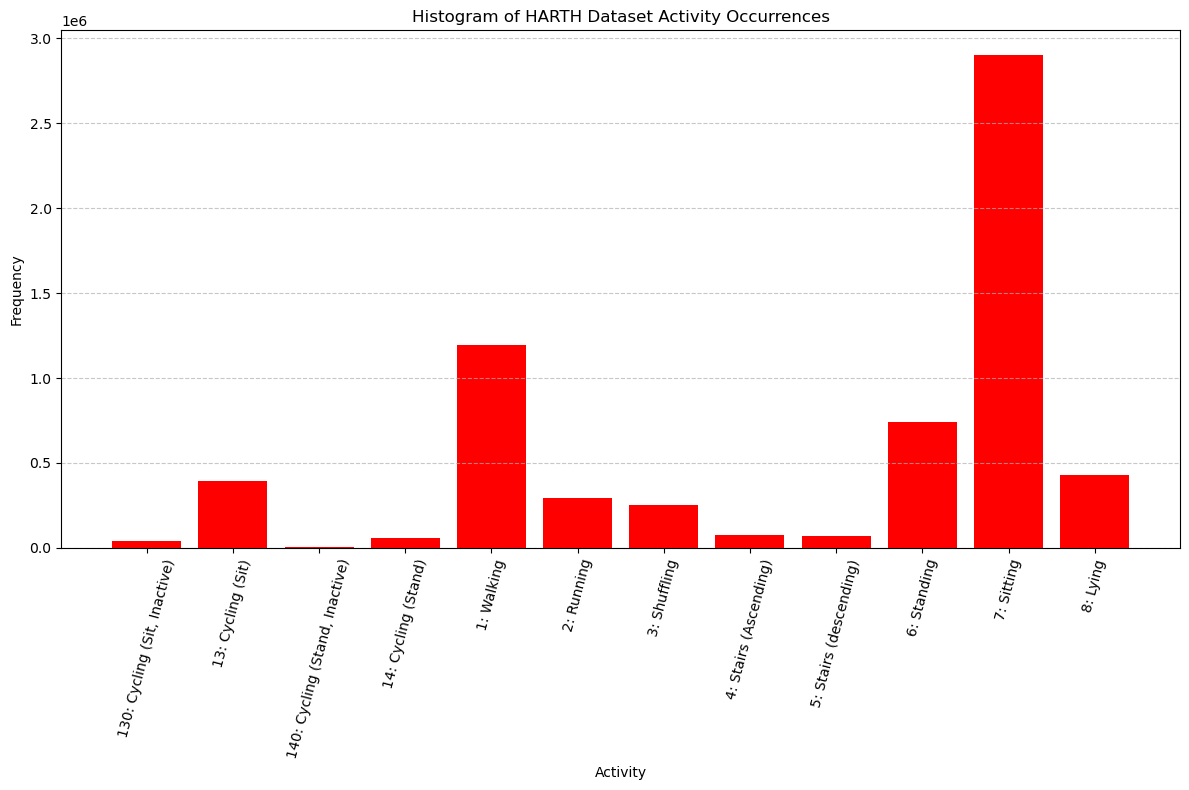

In [4]:
# Translation for HARTH sensor activity data
# Plot a histogram of all of the activity frequencies
# Map to descriptions for histogram plot
activity_label = {
    1: '1: Walking',
    2: '2: Running',
    3: '3: Shuffling',
    4: '4: Stairs (Ascending)',
    5: '5: Stairs (descending)',
    6: '6: Standing',
    7: '7: Sitting',
    8: '8: Lying',
    13: '13: Cycling (Sit)',
    14: '14: Cycling (Stand)',
    130: '130: Cycling (Sit, Inactive)',
    140: '140: Cycling (Stand, Inactive)'
}
# Copy and map the dataset for histogram plot
sensor_data_hist = sensor_data.copy()
# map activity to descriptions
sensor_data_hist['label'] = sensor_data_hist['label'].map(activity_label)
# count the occurrences
label_counts = sensor_data_hist['label'].value_counts().sort_index()
# Plot the histogram of the HARTH dataset activity frequencies
plt.figure(figsize=(12, 8))
plt.bar(label_counts.index, label_counts.values, color='red')
plt.xlabel('Activity')
plt.ylabel('Frequency')
plt.title('Histogram of HARTH Dataset Activity Occurrences')
plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Pre-processing
### Extract Six Back and Thigh Sensor Data Variables for the X, Y, Z axis
### Standardize, Scale, and Reshape Data

In [5]:
# Data Pre-processing
# Set up variables with specific data
# Extract the six back and thigh sensor data variables for the x, y, z axis
sensor = sensor_data[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']]
# extract the annotated activity using the label numbers
lab_activity = sensor_data[['label']]
# extract the timestamp data
times = sensor_data[['timestamp']]
X = sensor
y = lab_activity
# Set the number of sensor variables to six
num_vars = 6
# Number of rows in the data
sensor_len = len(sensor)
# Set step size for time series data to 1, each sample will be a single time step
step = 1
# Output shapes
print('\nSensor Data X:\n', X)
print('\nLabel Data y:\n', y)

#################################################################

# Data Pre-processing
# Convert all rows and columns of back and thigh sensor data to 2D array
X = sensor.iloc[:, :].values
# Convert all rows and columns of activity label data to 2D array
y = lab_activity.iloc[:, :].values

# Standardize the features. Initialize a StandardScaler object and standardize
# the features in X; scale them to have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Convert to a 3D array using reshape for dimensions [data_len, 1, 6]
X = X.reshape(sensor_len, step, num_vars)

# Convert labels to categorical
# Convert a vector of integer class labels into a binary class matrix.
# One-Hot Encoding transforms integer labels into a format suitable for
# multi-class classification problems in neural networks.
y = to_categorical(y)


Sensor Data X:
            back_x    back_y    back_z   thigh_x   thigh_y   thigh_z
0       -0.760242  0.299570  0.468570 -5.092732 -0.298644  0.709439
1       -0.530138  0.281880  0.319987  0.900547  0.286944  0.340309
2       -1.170922  0.186353 -0.167010 -0.035442 -0.078423 -0.515212
3       -0.648772  0.016579 -0.054284 -1.554248 -0.950978 -0.221140
4       -0.355071 -0.051831 -0.113419 -0.547471  0.140903 -0.653782
...           ...       ...       ...       ...       ...       ...
6461323 -1.012939 -0.110840 -0.218994 -0.970215 -0.313232  0.124268
6461324 -0.979492 -0.089355 -0.216553 -0.966553 -0.234619  0.113770
6461325 -0.969971 -0.057861 -0.204590 -0.997803 -0.097656  0.065186
6461326 -1.001953 -0.029785 -0.234863 -1.000000 -0.145996  0.061523
6461327 -1.015381 -0.030762 -0.218262 -1.000244 -0.305420  0.076904

[6461328 rows x 6 columns]

Label Data y:
          label
0            6
1            6
2            6
3            6
4            6
...        ...
6461323      3
646

## Bidirectional Long Short-Term Memory (LSTM) Model
### K-Fold Cross Validation Using 5 Splits

In [6]:
# Build a Bidirectional Long Short-Term Memory (LSTM) model
# using K-Fold Cross Validation
# Define the number of splits/folds to 5 for K-Fold
kf = KFold(n_splits = 5, shuffle=True, random_state=32)
# Store scores for each fold
scores = []

# K-Fold Cross Validation
# Index for training and validation splits
for train_index, val_index in kf.split(X):
    # Training and Validation sensor variables
    X_train, X_val = X[train_index], X[val_index]
    # Training and Validation labels
    y_train, y_val = y[train_index], y[val_index]

    # Build Bidirectional Long Short-Term Memory (LSTM) model
    # Initialize Sequential model
    model = Sequential()
    # Add a bidirectional LSTM layer with 64 units to the model. Ensure the LSTM
    # layer returns the full sequence of outputs for each input sequence.
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(step, num_vars)))
    # Add a dropout layer with a rate of 0.5 to prevent overfitting
    model.add(Dropout(0.5))
    # Add another bidirectional LSTM layer with 64 units; only the last output in
    # the sequence is returned
    model.add(Bidirectional(LSTM(64)))
    # Add another dropout layer with a rate of 0.5
    model.add(Dropout(0.5))
    # Add a dense fully connected layer with number of units = number of classes in y
    # Use softmax activation for multi-class classification
    model.add(Dense(y.shape[1], activation='softmax'))

    # Compile the model using adam optimizer, loss function categorical_crossentropy,
    # and accuracy as the metric
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model for 20 epochs with batch size of 64
    # Ensure that evaluation progress is printed to display (verbose=1)
    model.fit(X_train, y_train, epochs=1, batch_size=64, verbose=1)

    # Validate predicted vs true
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)
    # Calculate accuracy of predicted vs true
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    scores.append(accuracy)
    print(f'Fold Accuracy: {accuracy:.4f}')

# Print the average accuracy across all folds
print(f'\nAverage Accuracy: {np.mean(scores):.4f}\n')
# Output model summary
print(model.summary())

C:\Users\gregm\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80767/80767 ━━━━━━━━━━━━━━━━━━━━ 188s 2ms/step - accuracy: 0.8354 - loss: 0.5459
40384/40384 ━━━━━━━━━━━━━━━━━━━━ 31s 759us/step
Fold Accuracy: 0.8775


C:\Users\gregm\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80767/80767 ━━━━━━━━━━━━━━━━━━━━ 267s 3ms/step - accuracy: 0.8345 - loss: 0.5465
40384/40384 ━━━━━━━━━━━━━━━━━━━━ 34s 828us/step
Fold Accuracy: 0.8772


C:\Users\gregm\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80767/80767 ━━━━━━━━━━━━━━━━━━━━ 317s 4ms/step - accuracy: 0.8349 - loss: 0.5473
40384/40384 ━━━━━━━━━━━━━━━━━━━━ 32s 782us/step
Fold Accuracy: 0.8763


C:\Users\gregm\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80767/80767 ━━━━━━━━━━━━━━━━━━━━ 327s 4ms/step - accuracy: 0.8347 - loss: 0.5468
40384/40384 ━━━━━━━━━━━━━━━━━━━━ 33s 817us/step
Fold Accuracy: 0.8775


C:\Users\gregm\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80767/80767 ━━━━━━━━━━━━━━━━━━━━ 333s 4ms/step - accuracy: 0.8345 - loss: 0.5474
40384/40384 ━━━━━━━━━━━━━━━━━━━━ 31s 757us/step
Fold Accuracy: 0.8765

Average Accuracy: 0.8770



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (None, 1, 128)              │          36,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 141)                 │          18,189 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 460,073 (1.76 MB)

 Trainable params: 153,357 (599.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,716 (1.17 MB)

None


## Metabolic EquivalenT (MET) Calories Calculator
### MET Calories Calculations for Each HARTH Dataset File for All Activities Using Activity Time

In [7]:
# Use METs Calories Calculator to process ALL data files and
# calculate total calories burned for all activities for each subject
# https://media.hypersites.com/clients/1235/filemanager/MHC/METs.pdf
# Calories = (MET level of activity * 3.5 * Weight(kg) x minutes of activity) / 200

# Results showed that the gross energy cost of stair climbing is 8.6 METs,
# and stair descending is 2.9 METs. Thus, for a 70-kg person the
# Bicycling, <10mph, general, leisure, to work/for pleasure	4.0
# Bicycling, 10-12 mph, leisure, slow, light effort	6.0
# Bicycling, 12-14 mph, leisure, moderate effort	8.0
# Bicycling, 14-16 mph, racing or leisure, fast, vigorous effort	10.0
import pandas as pd

def calories(start_time_str, end_time_str, weight_kg, activitylab):
    # Input start time, end time, weight, and activity
    # Return calories burned
    from datetime import datetime
    # MET Levels (Metabolic EquivalenT) estimated for HARTH dataset activities
    activity_MET = {
        1: 2.5,  # Walking
        2: 10,   # Running
        3: 2.9,  # Shuffling
        4: 8.6,  # Stairs (Ascending)
        5: 2.9,  # Stairs (Descending)
        6: 2.5,  # Standing
        7: 1,    # Sitting
        8: 1,    # Lying
        13: 8,   # Cycling (Sit)
        14: 10,  # Cycling (Stand)
        130: 4,  # Cycling (Sit, Inactive)
        140: 6,  # Cycling (Stand, Inactive)
    }
    
    # Truncate start time to milliseconds
    parts = start_time_str.split('.')
    if len(parts[1]) > 3:
        # Keep only the first 3 digits of the decimal
        start_time_str = f"{parts[0]}.{parts[1][:3]}"
    # Truncate end time to milliseconds
    parts = end_time_str.split('.')
    if len(parts[1]) > 3:
        # Keep only the first 3 digits of the decimal
        end_time_str = f"{parts[0]}.{parts[1][:3]}"
    # Set time format
    time_form = "%Y-%m-%d %H:%M:%S.%f"
    # Extract start time
    start = datetime.strptime(start_time_str, time_form)
    # Extract end time of activity
    end = datetime.strptime(end_time_str, time_form)
    # Find diff between end time and start time
    duration = end - start
    # Convert seconds to minutes for MET calculations
    duration_minutes = duration.total_seconds() / 60
    # MET value for activity
    MET = activity_MET[activitylab]
    # calories = (MET level of activity * 3.5 * Weight(kg) x minutes of activity) / 200
    calories_burned = (MET * 3.5 * weight_kg * duration_minutes) / 200
    return calories_burned

#############################################################

# Process all sensor data from all test subjects and
# generate MET Total Calories for each subject sensor file
# using timestamps and activity

for dataset in data_files:
    print('\nName of HARTH Sensor Data File:', dataset)
    METdata = data_files[dataset]
    # extract the annotated activity using the label numbers
    act_label = METdata['label']
    # extract the timestamp data
    timestamp = METdata['timestamp']
    # Assume 70kg weight for application
    weight = 70
    # Initialize variables
    total_cals = 0
    start_time = timestamp.values[0]
    end_time = timestamp.values[0]
    activity = act_label.values[0]
    for i in range(len(timestamp)):
        # if activity label changes then find the calories for activity
        if (activity != act_label[i]):
            # Add to MET Total Calories
            total_cals = total_cals + calories(start_time, end_time, weight, activity)
            # Reset for next activity in sensor data
            activity = act_label[i]
            start_time = timestamp[i]
            end_time = timestamp[i]
        else:
            # Set end time to next value
            end_time = timestamp[i]
    
    print('Total MET Calories for all activities: %5.2f' % total_cals)


Name of HARTH Sensor Data File: S006.csv
Total MET Calories for all activities: 162.69

Name of HARTH Sensor Data File: S008.csv
Total MET Calories for all activities: 278.09

Name of HARTH Sensor Data File: S009.csv
Total MET Calories for all activities: 467.61

Name of HARTH Sensor Data File: S010.csv
Total MET Calories for all activities: 369.37

Name of HARTH Sensor Data File: S012.csv
Total MET Calories for all activities: 203.26

Name of HARTH Sensor Data File: S013.csv
Total MET Calories for all activities: 274.02

Name of HARTH Sensor Data File: S014.csv
Total MET Calories for all activities: 275.00

Name of HARTH Sensor Data File: S015.csv
Total MET Calories for all activities: 309.19

Name of HARTH Sensor Data File: S016.csv
Total MET Calories for all activities: 266.07

Name of HARTH Sensor Data File: S017.csv
Total MET Calories for all activities: 274.58

Name of HARTH Sensor Data File: S018.csv
Total MET Calories for all activities: 298.53

Name of HARTH Sensor Data File:

## Application to Process HAR Sensor Data, Predict Activity, Calculate MET Calories
### Use 13 - Cycling (Sit) Sensor Data For Each Test Subject HARTH Dataset File

In [8]:
# Use the Bidirectional Long Short-Term Memory (LSTM) model
# to predict the activity on known activity sensor data and then
# use METs Calories Calculator to calculate the calories
# https://media.hypersites.com/clients/1235/filemanager/MHC/METs.pdf
# Calories = (MET level of activity * 3.5 * Weight(kg) x minutes of activity) / 200

# Results showed that the gross energy cost of stair climbing is 8.6 METs,
# and stair descending is 2.9 METs. Thus, for a 70-kg person the
# Bicycling, <10mph, general, leisure, to work/for pleasure	4.0
# Bicycling, 10-12 mph, leisure, slow, light effort	6.0
# Bicycling, 12-14 mph, leisure, moderate effort	8.0
# Bicycling, 14-16 mph, racing or leisure, fast, vigorous effort	10.0
import pandas as pd

def calories(start_time_str, end_time_str, weight_kg, activitylab):
    # Input start time, end time, weight, and activity
    # Return calories burned
    from datetime import datetime
    # MET Levels (Metabolic EquivalenT) estimated for HARTH dataset activities
    activity_MET = {
        1: 2.5,  # Walking
        2: 10,   # Running
        3: 2.9,  # Shuffling
        4: 8.6,  # Stairs (Ascending)
        5: 2.9,  # Stairs (Descending)
        6: 2.5,  # Standing
        7: 1,    # Sitting
        8: 1,    # Lying
        13: 8,   # Cycling (Sit)
        14: 10,  # Cycling (Stand)
        130: 4,  # Cycling (Sit, Inactive)
        140: 6,  # Cycling (Stand, Inactive)
    }
    
    # Truncate start time to milliseconds
    parts = start_time_str.split('.')
    if len(parts[1]) > 3:
        # Keep only the first 3 digits of the decimal
        start_time_str = f"{parts[0]}.{parts[1][:3]}"
    # Truncate end time to milliseconds
    parts = end_time_str.split('.')
    if len(parts[1]) > 3:
        # Keep only the first 3 digits of the decimal
        end_time_str = f"{parts[0]}.{parts[1][:3]}"
    # Set time format
    time_form = "%Y-%m-%d %H:%M:%S.%f"
    # Extract start time
    start = datetime.strptime(start_time_str, time_form)
    # Extract end time of activity
    end = datetime.strptime(end_time_str, time_form)
    # Find diff between end time and start time
    duration = end - start
    # Convert seconds to minutes for MET calculations
    duration_minutes = duration.total_seconds() / 60
    # MET value for activity
    MET = activity_MET[activitylab]
    # calories = (MET level of activity * 3.5 * Weight(kg) x minutes of activity) / 200
    calories_burned = (MET * 3.5 * weight_kg * duration_minutes) / 200
    return calories_burned

#############################################################

# Process a subset of the data for known activity sensor data
# Use the Bidirectional Long Short-Term Memory (LSTM) model
# to predict the activity for a few activities and then
# use METs Calories Calculator to calculate the calories

activity_label_test = {
    1: '1-Walking',
    2: '2-Running',
    3: '3-Shuffling',
    4: '4-Stairs (Ascending)',
    5: '5-Stairs (descending)',
    6: '6-Standing',
    7: '7-Sitting',
    8: '8-Lying',
    13: '13-Cycling (Sit)',
    14: '14-Cycling (Stand)',
    130: '130-Cycling (Sit, Inactive)',
    140: '140-Cycling (Stand, Inactive)'
}

# Process all sensor data from all test subjects and
# generate MET Total Calories for one activity for each subject
# sensor file using timestamps, sensor data, and activity

for dataset in data_files:
    print('\nName of HARTH Sensor Data File:', dataset)
    METdata = data_files[dataset]
    # Select known activity sensor data for testing predictor
    sensor_data_test = METdata[METdata['label'] == 13]
    if sensor_data_test.empty:
        print(f'No Data with Activity 13 in {dataset}.')
        continue
    sensor_data_test = sensor_data_test.head(10000)
    # Extract the six back and thigh sensor data variables for
    # the x, y, z axis and timestamp data
    sensor = sensor_data_test[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']]
    # extract the timestamp data
    times = sensor_data_test['timestamp']
    # extract the annotated activity using the label numbers
    activity = sensor_data_test['label']
    activity = activity.values[0]
    # Set the number of sensor variables to six
    num_vars = 6
    # Get number of samples
    new_data_len = len(sensor_data_test)
    # Set step size for time series data to 1, each sample will be a single time step
    step = 1
    # Scale the features in the sensor data
    sensor = scaler.transform(sensor.values)
    # Convert to a 3D array using reshape for dimensions [data_len, 1, 6]
    sensor = sensor.reshape((new_data_len, step, num_vars))
    # Predict the activity label for the known Standing activity data
    prediction = model.predict(sensor)
    predictionmax = np.argmax(prediction)
    pred_activity = lab_activity.iloc[predictionmax,0]
    print(f'Predicted vs True Sensor Data Activity for {activity_label_test[activity]}')
    print('Predicted Activity Index:', predictionmax)
    print(f'True Activity: {activity_label_test[activity]}')
    print(f'Predicted Activity: {activity_label_test[pred_activity]}')
    
    # Call function calories() to calculate calories burned using
    # MET calculator on known Standing data
    # Assume 70kg weight for application
    weight = 70
    # Set variables
    start_time = times.values[0]
    end_time = times.values[-1]
    # Call calories() function to get calories burned
    total_cals = calories(start_time, end_time, weight, activity)
    #print('\nTotal MET Calories for Standing: %5.2f\n' % total_cals)
    print(f'Total MET Calories Burned for {activity_label_test[pred_activity]} :%5.2f' % total_cals)


Name of HARTH Sensor Data File: S006.csv
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicted vs True Sensor Data Activity for 13-Cycling (Sit)
Predicted Activity Index: 712903
True Activity: 13-Cycling (Sit)
Predicted Activity: 7-Sitting
Total MET Calories Burned for 7-Sitting :24.57

Name of HARTH Sensor Data File: S008.csv
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Predicted vs True Sensor Data Activity for 13-Cycling (Sit)
Predicted Activity Index: 192896
True Activity: 13-Cycling (Sit)
Predicted Activity: 7-Sitting
Total MET Calories Burned for 7-Sitting :30.10

Name of HARTH Sensor Data File: S009.csv
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
Predicted vs True Sensor Data Activity for 13-Cycling (Sit)
Predicted Activity Index: 1322587
True Activity: 13-Cycling (Sit)
Predicted Activity: 3-Shuffling
Total MET Calories Burned for 3-Shuffling :32.66

Name of HARTH Sensor Data File: S010.csv
No Data with Activity 13 in S010.csv.

Name of HARTH Sensor Data File: S012.csv
No Data with Act

## Application to Process HAR Sensor Data, Predict Activity, Calculate MET Calories
### Use 6 - Standing Sensor Data For Each Test Subject HARTH Dataset File

In [9]:
# Use the Bidirectional Long Short-Term Memory (LSTM) model
# to predict the activity on known activity sensor data and then
# use METs Calories Calculator to calculate the calories
# https://media.hypersites.com/clients/1235/filemanager/MHC/METs.pdf
# Calories = (MET level of activity * 3.5 * Weight(kg) x minutes of activity) / 200

# Results showed that the gross energy cost of stair climbing is 8.6 METs,
# and stair descending is 2.9 METs. Thus, for a 70-kg person the
# Bicycling, <10mph, general, leisure, to work/for pleasure	4.0
# Bicycling, 10-12 mph, leisure, slow, light effort	6.0
# Bicycling, 12-14 mph, leisure, moderate effort	8.0
# Bicycling, 14-16 mph, racing or leisure, fast, vigorous effort	10.0
import pandas as pd

def calories(start_time_str, end_time_str, weight_kg, activitylab):
    # Input start time, end time, weight, and activity
    # Return calories burned
    from datetime import datetime
    # MET Levels (Metabolic EquivalenT) estimated for HARTH dataset activities
    activity_MET = {
        1: 2.5,  # Walking
        2: 10,   # Running
        3: 2.9,  # Shuffling
        4: 8.6,  # Stairs (Ascending)
        5: 2.9,  # Stairs (Descending)
        6: 2.5,  # Standing
        7: 1,    # Sitting
        8: 1,    # Lying
        13: 8,   # Cycling (Sit)
        14: 10,  # Cycling (Stand)
        130: 4,  # Cycling (Sit, Inactive)
        140: 6,  # Cycling (Stand, Inactive)
    }
    
    # Truncate start time to milliseconds
    parts = start_time_str.split('.')
    if len(parts[1]) > 3:
        # Keep only the first 3 digits of the decimal
        start_time_str = f"{parts[0]}.{parts[1][:3]}"
    # Truncate end time to milliseconds
    parts = end_time_str.split('.')
    if len(parts[1]) > 3:
        # Keep only the first 3 digits of the decimal
        end_time_str = f"{parts[0]}.{parts[1][:3]}"
    # Set time format
    time_form = "%Y-%m-%d %H:%M:%S.%f"
    # Extract start time
    start = datetime.strptime(start_time_str, time_form)
    # Extract end time of activity
    end = datetime.strptime(end_time_str, time_form)
    # Find diff between end time and start time
    duration = end - start
    # Convert seconds to minutes for MET calculations
    duration_minutes = duration.total_seconds() / 60
    # MET value for activity
    MET = activity_MET[activitylab]
    # calories = (MET level of activity * 3.5 * Weight(kg) x minutes of activity) / 200
    calories_burned = (MET * 3.5 * weight_kg * duration_minutes) / 200
    return calories_burned

#############################################################

# Process a subset of the data for known activity sensor data
# Use the Bidirectional Long Short-Term Memory (LSTM) model
# to predict the activity for a few activities and then
# use METs Calories Calculator to calculate the calories

activity_label_test = {
    1: '1-Walking',
    2: '2-Running',
    3: '3-Shuffling',
    4: '4-Stairs (Ascending)',
    5: '5-Stairs (descending)',
    6: '6-Standing',
    7: '7-Sitting',
    8: '8-Lying',
    13: '13-Cycling (Sit)',
    14: '14-Cycling (Stand)',
    130: '130-Cycling (Sit, Inactive)',
    140: '140-Cycling (Stand, Inactive)'
}

# Process all sensor data from all test subjects and
# generate MET Total Calories for one activity for each subject
# sensor file using timestamps, sensor data, and activity

for dataset in data_files:
    print('\nName of HARTH Sensor Data File:', dataset)
    METdata = data_files[dataset]
    # Select known activity sensor data for testing predictor
    sensor_data_test = METdata[METdata['label'] == 6]
    if sensor_data_test.empty:
        print(f'No Data with Activity 6 in {dataset}.')
        continue
    sensor_data_test = sensor_data_test.head(10000)
    # Extract the six back and thigh sensor data variables for
    # the x, y, z axis and timestamp data
    sensor = sensor_data_test[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']]
    # extract the timestamp data
    times = sensor_data_test['timestamp']
    # extract the annotated activity using the label numbers
    activity = sensor_data_test['label']
    activity = activity.values[0]
    # Set the number of sensor variables to six
    num_vars = 6
    # Get number of samples
    new_data_len = len(sensor_data_test)
    # Set step size for time series data to 1, each sample will be a single time step
    step = 1
    # Scale the features in the sensor data
    sensor = scaler.transform(sensor.values)
    # Convert to a 3D array using reshape for dimensions [data_len, 1, 6]
    sensor = sensor.reshape((new_data_len, step, num_vars))
    # Predict the activity label for the known Standing activity data
    prediction = model.predict(sensor)
    predictionmax = np.argmax(prediction)
    pred_activity = lab_activity.iloc[predictionmax,0]
    print(f'Predicted vs True Sensor Data Activity for {activity_label_test[activity]}')
    print('Predicted Activity Index:', predictionmax)
    print(f'True Activity: {activity_label_test[activity]}')
    print(f'Predicted Activity: {activity_label_test[pred_activity]}')
    
    # Call function calories() to calculate calories burned using
    # MET calculator on known Standing data
    # Assume 70kg weight for application
    weight = 70
    # Set variables
    start_time = times.values[0]
    end_time = times.values[-1]
    # Call calories() function to get calories burned
    total_cals = calories(start_time, end_time, weight, activity)
    #print('\nTotal MET Calories for Standing: %5.2f\n' % total_cals)
    print(f'Total MET Calories Burned for {activity_label_test[pred_activity]} :%5.2f' % total_cals)


Name of HARTH Sensor Data File: S006.csv
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicted vs True Sensor Data Activity for 6-Standing
Predicted Activity Index: 706
True Activity: 6-Standing
Predicted Activity: 6-Standing
Total MET Calories Burned for 6-Standing : 5.42

Name of HARTH Sensor Data File: S008.csv
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predicted vs True Sensor Data Activity for 6-Standing
Predicted Activity Index: 566
True Activity: 6-Standing
Predicted Activity: 6-Standing
Total MET Calories Burned for 6-Standing :12.48

Name of HARTH Sensor Data File: S009.csv
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predicted vs True Sensor Data Activity for 6-Standing
Predicted Activity Index: 816674
True Activity: 6-Standing
Predicted Activity: 7-Sitting
Total MET Calories Burned for 7-Sitting :158.32

Name of HARTH Sensor Data File: S010.csv
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predicted vs True Sensor Data Activity for 6-Standing
Predicted Activity Index: 1353324
True Activi

## Application to Process HAR Sensor Data, Predict Activity, Calculate MET Calories
### Use 8 - Lying Sensor Data For Each Test Subject HARTH Dataset File

In [10]:
# Use the Bidirectional Long Short-Term Memory (LSTM) model
# to predict the activity on known activity sensor data and then
# use METs Calories Calculator to calculate the calories
# https://media.hypersites.com/clients/1235/filemanager/MHC/METs.pdf
# Calories = (MET level of activity * 3.5 * Weight(kg) x minutes of activity) / 200

# Results showed that the gross energy cost of stair climbing is 8.6 METs,
# and stair descending is 2.9 METs. Thus, for a 70-kg person the
# Bicycling, <10mph, general, leisure, to work/for pleasure	4.0
# Bicycling, 10-12 mph, leisure, slow, light effort	6.0
# Bicycling, 12-14 mph, leisure, moderate effort	8.0
# Bicycling, 14-16 mph, racing or leisure, fast, vigorous effort	10.0
import pandas as pd

def calories(start_time_str, end_time_str, weight_kg, activitylab):
    # Input start time, end time, weight, and activity
    # Return calories burned
    from datetime import datetime
    # MET Levels (Metabolic EquivalenT) estimated for HARTH dataset activities
    activity_MET = {
        1: 2.5,  # Walking
        2: 10,   # Running
        3: 2.9,  # Shuffling
        4: 8.6,  # Stairs (Ascending)
        5: 2.9,  # Stairs (Descending)
        6: 2.5,  # Standing
        7: 1,    # Sitting
        8: 1,    # Lying
        13: 8,   # Cycling (Sit)
        14: 10,  # Cycling (Stand)
        130: 4,  # Cycling (Sit, Inactive)
        140: 6,  # Cycling (Stand, Inactive)
    }
    
    # Truncate start time to milliseconds
    parts = start_time_str.split('.')
    if len(parts[1]) > 3:
        # Keep only the first 3 digits of the decimal
        start_time_str = f"{parts[0]}.{parts[1][:3]}"
    # Truncate end time to milliseconds
    parts = end_time_str.split('.')
    if len(parts[1]) > 3:
        # Keep only the first 3 digits of the decimal
        end_time_str = f"{parts[0]}.{parts[1][:3]}"
    # Set time format
    time_form = "%Y-%m-%d %H:%M:%S.%f"
    # Extract start time
    start = datetime.strptime(start_time_str, time_form)
    # Extract end time of activity
    end = datetime.strptime(end_time_str, time_form)
    # Find diff between end time and start time
    duration = end - start
    # Convert seconds to minutes for MET calculations
    duration_minutes = duration.total_seconds() / 60
    # MET value for activity
    MET = activity_MET[activitylab]
    # calories = (MET level of activity * 3.5 * Weight(kg) x minutes of activity) / 200
    calories_burned = (MET * 3.5 * weight_kg * duration_minutes) / 200
    return calories_burned

#############################################################

# Process a subset of the data for known activity sensor data
# Use the Bidirectional Long Short-Term Memory (LSTM) model
# to predict the activity for a few activities and then
# use METs Calories Calculator to calculate the calories

activity_label_test = {
    1: '1-Walking',
    2: '2-Running',
    3: '3-Shuffling',
    4: '4-Stairs (Ascending)',
    5: '5-Stairs (descending)',
    6: '6-Standing',
    7: '7-Sitting',
    8: '8-Lying',
    13: '13-Cycling (Sit)',
    14: '14-Cycling (Stand)',
    130: '130-Cycling (Sit, Inactive)',
    140: '140-Cycling (Stand, Inactive)'
}

# Process all sensor data from all test subjects and
# generate MET Total Calories for one activity for each subject
# sensor file using timestamps, sensor data, and activity

for dataset in data_files:
    print('\nName of HARTH Sensor Data File:', dataset)
    METdata = data_files[dataset]
    # Select known activity sensor data for testing predictor
    sensor_data_test = METdata[METdata['label'] == 8]
    if sensor_data_test.empty:
        print(f'No Data with Activity 8 in {dataset}.')
        continue
    sensor_data_test = sensor_data_test.head(10000)
    # Extract the six back and thigh sensor data variables for
    # the x, y, z axis and timestamp data
    sensor = sensor_data_test[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']]
    # extract the timestamp data
    times = sensor_data_test['timestamp']
    # extract the annotated activity using the label numbers
    activity = sensor_data_test['label']
    activity = activity.values[0]
    # Set the number of sensor variables to six
    num_vars = 6
    # Get number of samples
    new_data_len = len(sensor_data_test)
    # Set step size for time series data to 1, each sample will be a single time step
    step = 1
    # Scale the features in the sensor data
    sensor = scaler.transform(sensor.values)
    # Convert to a 3D array using reshape for dimensions [data_len, 1, 6]
    sensor = sensor.reshape((new_data_len, step, num_vars))
    # Predict the activity label for the known Standing activity data
    prediction = model.predict(sensor)
    predictionmax = np.argmax(prediction)
    pred_activity = lab_activity.iloc[predictionmax,0]
    print(f'Predicted vs True Sensor Data Activity for {activity_label_test[activity]}')
    print('Predicted Activity Index:', predictionmax)
    print(f'True Activity: {activity_label_test[activity]}')
    print(f'Predicted Activity: {activity_label_test[pred_activity]}')
    
    # Call function calories() to calculate calories burned using
    # MET calculator on known Standing data
    # Assume 70kg weight for application
    weight = 70
    # Set variables
    start_time = times.values[0]
    end_time = times.values[-1]
    # Call calories() function to get calories burned
    total_cals = calories(start_time, end_time, weight, activity)
    #print('\nTotal MET Calories for Standing: %5.2f\n' % total_cals)
    print(f'Total MET Calories Burned for {activity_label_test[pred_activity]} :%5.2f' % total_cals)


Name of HARTH Sensor Data File: S006.csv
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
Predicted vs True Sensor Data Activity for 8-Lying
Predicted Activity Index: 10301
True Activity: 8-Lying
Predicted Activity: 6-Standing
Total MET Calories Burned for 6-Standing : 2.08

Name of HARTH Sensor Data File: S008.csv
No Data with Activity 8 in S008.csv.

Name of HARTH Sensor Data File: S009.csv
No Data with Activity 8 in S009.csv.

Name of HARTH Sensor Data File: S010.csv
No Data with Activity 8 in S010.csv.

Name of HARTH Sensor Data File: S012.csv
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
Predicted vs True Sensor Data Activity for 8-Lying
Predicted Activity Index: 1357697
True Activity: 8-Lying
Predicted Activity: 7-Sitting
Total MET Calories Burned for 7-Sitting : 4.19

Name of HARTH Sensor Data File: S013.csv
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
Predicted vs True Sensor Data Activity for 8-Lying
Predicted Activity Index: 79391
True Activity: 8-Lying
Predicted Activity: 7-Sitting
To